## Initialisation de la session Spark

In [1]:
import sys
sys.path.append("../scripts")

from spark import init_spark

spark = init_spark()

## Chargement des données

In [2]:
sys.path.append("../src/data")
from load_data import load_data

In [3]:
data_path = "../data/raw/spanish_train_ticket_prices.csv"

df = load_data(data_path, spark)

Données chargées avec succès.


In [4]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- company: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- departure: timestamp (nullable = true)
 |-- arrival: timestamp (nullable = true)
 |-- duration: double (nullable = true)
 |-- vehicle_type: string (nullable = true)
 |-- vehicle_class: string (nullable = true)
 |-- price: double (nullable = true)
 |-- fare: string (nullable = true)
 |-- seats: integer (nullable = true)
 |-- meta: string (nullable = true)
 |-- insert_date: string (nullable = true)



## Traitement des valeurs manquantes

In [5]:
missing_values = (
        df.select([(df[col].isNull().cast("int").alias(col)) for col in df.columns])
        .groupBy()
        .sum()
        .toPandas()
        .T.rename(columns={0: "missing_values"})
    )

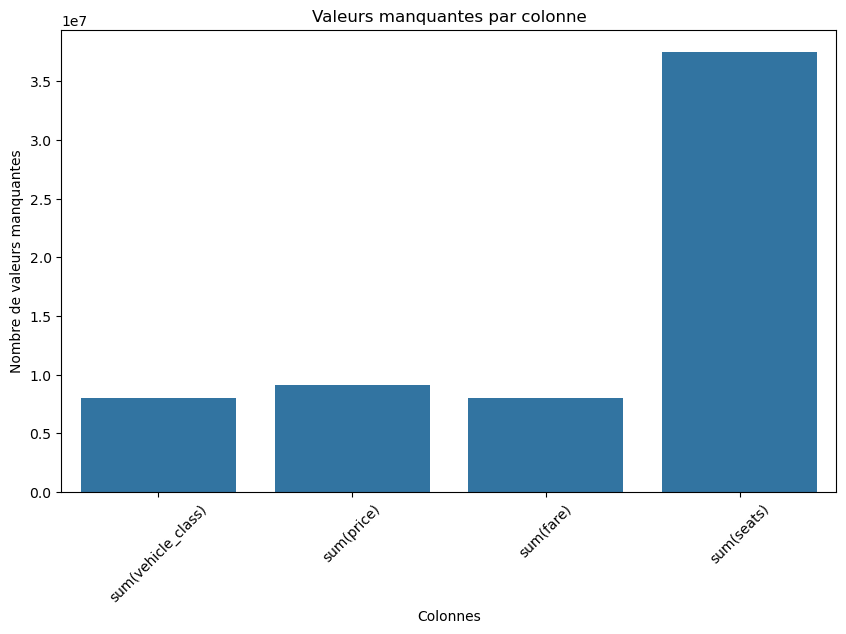

In [6]:
sys.path.append("../src/visualization")
from distribution import dist_missing

missing_values = missing_values.reset_index()
missing_values.columns = ["column", "missing_values"]
missing_values = missing_values[missing_values["missing_values"] > 0]

dist_missing(missing_values)

In [7]:
from process_data import handle_missing_values
df = handle_missing_values(df)


Valeurs manquantes après traitement :
                    missing_values
sum(id)                          0
sum(company)                     0
sum(origin)                      0
sum(destination)                 0
sum(departure)                   0
sum(arrival)                     0
sum(duration)                    0
sum(vehicle_type)                0
sum(vehicle_class)               0
sum(price)                       0
sum(fare)                        0


Distribution des prix des billets

In [8]:
from distribution import dist_ticket_price
#dist_ticket_price(df)

Distribution des types de véhicules

In [9]:
from distribution import dist_vehicle_type
#dist_vehicle_type(df)

Prix par type de véhicule et classe

In [10]:
from distribution import dist_price_by_vehicle_class
#dist_price_by_vehicle_class(df)

Prix par origine et destination

In [11]:
from distribution import dist_price_by_origin_destination
#dist_price_by_origin_destination(df)

Analyse temporelle

In [12]:
from process_data import handle_date_data
df = handle_date_data(df)

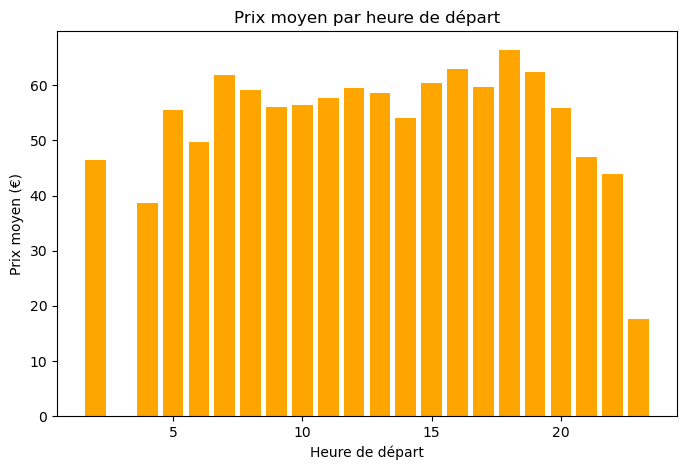

In [13]:
from distribution import dist_mean_price_by_departure_hour
dist_mean_price_by_departure_hour(df)

## Traitement des données pour entrainelent des modèles

In [14]:
from process_data import process_data

df = process_data(df)

In [15]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- company: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- departure: timestamp (nullable = true)
 |-- arrival: timestamp (nullable = true)
 |-- duration: double (nullable = true)
 |-- vehicle_type: string (nullable = true)
 |-- vehicle_class: string (nullable = true)
 |-- price: double (nullable = true)
 |-- fare: string (nullable = true)
 |-- departure_hour: integer (nullable = true)
 |-- departure_day: integer (nullable = true)
 |-- departure_month: integer (nullable = true)
 |-- vehicle_type_index: double (nullable = false)
 |-- vehicle_class_index: double (nullable = false)
 |-- fare_index: double (nullable = false)
 |-- origin_index: double (nullable = false)
 |-- destination_index: double (nullable = false)
 |-- features: vector (nullable = true)



## Division des données en données d'entrainement et de test

In [16]:
sys.path.append("../src/models")

from train_test_split import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2)

Ensemble d'entraînement : 23674558 lignes
Ensemble de test : 5918553 lignes


## Entrainement du modèle Régression Linéaire

In [17]:
from linear_regression import train_linear_regression
lr_model = train_linear_regression(train_df, test_df)

## Evaluation du modèle Régression Linéaire

In [18]:
from evaluate import evaluate_model
lr_metrics = evaluate_model(lr_model)

RMSE (Root Mean Squared Error): 22.77
MAE (Mean Absolute Error): 17.93
R² (Coefficient de Détermination): 0.16


## Entrainement et évaluation du modèle Arbre de Décision

In [19]:
from decision_tree import train_decision_tree
dt_model = train_decision_tree(train_df, test_df)
dt_metrics = evaluate_model(dt_model)

RMSE (Root Mean Squared Error): 11.43
MAE (Mean Absolute Error): 8.40
R² (Coefficient de Détermination): 0.79


## Entrainement et évaluation du modèle Forêts Aléatiores

In [20]:
from random_forest import train_random_forest
rf_model = train_random_forest(train_df, test_df)
rf_metrics = evaluate_model(rf_model)

RMSE (Root Mean Squared Error): 11.39
MAE (Mean Absolute Error): 8.38
R² (Coefficient de Détermination): 0.79


## Entrainement et évaluation du modèle Gradient Boosting

In [21]:
#from gradient_boosting import train_gradient_boosting
#gb_model = train_gradient_boosting(train_df, test_df)
#gb_metrics = evaluate_model(gb_model)

## Comparaison des résultats des modèles

In [22]:
import pandas as pd

metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'Metrics': [lr_metrics, dt_metrics, rf_metrics, "?"]
})

print(metrics_df)

               Model                                            Metrics
0  Linear Regression  {'rmse': 22.77276100487413, 'mae': 17.92646610...
1      Decision Tree  {'rmse': 11.428128914706035, 'mae': 8.40089121...
2      Random Forest  {'rmse': 11.385191805882714, 'mae': 8.38121365...
3  Gradient Boosting                                                  ?
